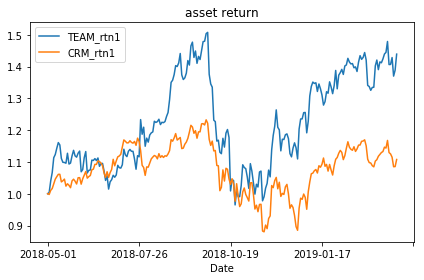

In [2]:
### User's questions
#-- 1. what's the price change of these assets (done in WTB - User1)
#-- 2. if I fix invest, what are the return by asset
#-- 3. what are the return as a portfolio (done in WTB - Port)

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

#--------------------------------------------------------------------
#-- 1. what's the price change of these assets (same as WTB - User1)
#--------------------------------------------------------------------
# User input: Assets, time window, need return

assets_df = pd.read_csv('assets.csv')
start_date = '2018-05-01'
price_col = '"Adj Close"' # SQL needs double quotes on field name w space

#---------------------------------------------------------------------
#-- 2. get x = Date, ys = assets prices, qty_chgs to reflect strategy
#---------------------------------------------------------------------
asset_price_cols = """
 SUM(CASE WHEN AID='TEAM' THEN {price_col} ELSE 0 END) as TEAM_price
,SUM(CASE WHEN AID='CRM' THEN {price_col} ELSE 0 END) as CRM_price
""".format(price_col=price_col)

# day 1 buy
asset_qty_chg_cols = """
 SUM(CASE WHEN AID='TEAM' AND strftime('%d', Date) = '01' then 1000/"Adj Close" ELSE 0 END) as TEAM_qty_chg
,SUM(CASE WHEN AID='CRM' AND strftime('%d', Date) = '01' then 1000/"Adj Close" ELSE 0 END) as CRM_qty_chg
""".format(start_date=start_date)

q = """SELECT 
      YMD
     ,{asset_price_cols}
     ,{asset_qty_chg_cols}
    FROM assets_df
    WHERE Date >= '{start_date}'
    GROUP BY YMD
    ORDER BY YMD
    ;""".format(start_date=start_date, asset_price_cols=asset_price_cols, asset_qty_chg_cols=asset_qty_chg_cols)

assets_df2 = pysqldf(q)

#-------------------------------------------------------------------
#-- 3. get return based on qty_chg (same as WTB - User1)
#-------------------------------------------------------------------

def get_return1(df, qty_chg_col, price_col, rtn1_col):
    df[rtn1_col] = (df[qty_chg_col].cumsum() * df[price_col]) / (df[qty_chg_col]*df[price_col]).cumsum()
    return df

assets_df2 = get_return1(assets_df2, qty_chg_col='TEAM_qty_chg', price_col='TEAM_price', rtn1_col='TEAM_rtn1')
assets_df2 = get_return1(assets_df2, qty_chg_col='CRM_qty_chg', price_col='CRM_price', rtn1_col='CRM_rtn1')

#-------------------------------------------------
#-- 4. plot return1 by asset (same as WTB - User1)
#-------------------------------------------------
def get_chart(df, asset_cols):
    
    x1 = df['YMD']
    y1 = df[asset_cols]

    fig, ax1 = plt.subplots()

    #-- plot
    ax1.plot(x1, y1) # 

    #-- x1(date)
    plt.xticks(x1) # x1(Date)
    ax1.set_xlabel('Date')

    #-- set max xaxis n ticks
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    
    #-- plot title
    plt.title('asset return')
    
    #-- plot legend
    plt.legend(asset_cols)

    #-- plot tight_layout, show
    plt.tight_layout()
    plt.show()
    
get_chart(df=assets_df2, asset_cols=['TEAM_rtn1','CRM_rtn1'])